# 多头自身注意力（Multi-Head Self-Attention）的实现

[Self Attention Training Tutorial](https://colab.research.google.com/drive/1d7qfwr32lkq3hZEZ1jNaIJ7Rz8zLNkfl)中讲了single-head self-attention的实现及训练方式。

本Notebook讲解：

1. Multi-Head Self-Attention理论上直观的实现方式（Attention is All You Need论文中的做法）
2. Multi-Head Self-Attention最常见的实现方式（现有语言模型中常见的做法）
3. 从理论到常见实现的演变过程是怎样的

## 0. 加载需要用到的数据

我们仍然使用股票的时序预测数据。直接将[Self Attention Training Tutorial](https://colab.research.google.com/drive/1d7qfwr32lkq3hZEZ1jNaIJ7Rz8zLNkfl)中的代码迁移过来，稍作修改：

In [ ]:
!wget https://raw.githubusercontent.com/Liadrinz/ml-tutorial/refs/heads/main/MARUTI.csv

--2024-12-05 10:01:54--  https://raw.githubusercontent.com/Liadrinz/ml-tutorial/refs/heads/main/MARUTI.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 488885 (477K) [text/plain]
Saving to: ‘MARUTI.csv.5’

MARUTI.csv.5        100%[===================>] 477.43K  --.-KB/s    in 0.07s   

2024-12-05 10:01:54 (6.60 MB/s) - ‘MARUTI.csv.5’ saved [488885/488885]



In [ ]:
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from scipy.special import softmax

In [ ]:
np.random.seed(42)
torch.random.manual_seed(42)
torch.manual_seed(42)

In [ ]:
class StockDataset(Dataset):

  def __init__(self, data_frame):
    super().__init__()
    self.data = data_frame.iloc[:, 1:]
    self.seq_lens = [np.random.randint(3, 6) for _ in range(len(self.data))]

  def __getitem__(self, idx):
    i = idx + 5  # 跳过最开始的5个交易日
    y = self.data["Open"].iloc[i]
    seq_len = self.seq_lens[i]  # 随机考虑3-5个交易日
    X = self.data.iloc[i-seq_len:i]
    return np.array(X), np.array(y)

  def __len__(self):
    return len(self.data) - 5


class PaddedStockDataset(Dataset):

  def __init__(self, org_dataset):
    self.org_dataset = org_dataset

  def __getitem__(self, idx):
    X, y = self.org_dataset[idx]
    pad_len = 5 - X.shape[0]
    padding = np.zeros((pad_len, 6))
    X_padded = np.concatenate([X, padding])
    attention_mask = np.array([1 if i < X.shape[0] else 0 for i in range(5)])
    return X_padded, y, attention_mask


  def __len__(self):
    return len(self.org_dataset)

In [ ]:
data = pd.read_csv("MARUTI.csv")

data_selected = data[["Date", "Prev Close", "Open", "High", "Low", "Last", "Close"]]

data_train = data_selected.iloc[:-100]
data_test = data_selected.iloc[-100:]

dataset_train = PaddedStockDataset(StockDataset(data_train))
dataset_test = PaddedStockDataset(StockDataset(data_test))

loader_train = DataLoader(dataset_train, batch_size=1)
loader_test = DataLoader(dataset_test, batch_size=1)

In [ ]:
for batch in loader_train:
  X, y, mask = batch
  print(X)
  print(y)
  print(mask)
  print(X.shape)
  print(y.shape)
  print(mask.shape)
  break

tensor([[[167.0000, 167.7500, 174.8500, 166.2500, 173.6000, 173.3500],
         [173.3500, 174.2500, 179.2500, 174.2500, 178.6000, 177.9500],
         [177.9500, 200.0000, 200.0000, 173.0000, 176.3000, 176.2000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]]],
       dtype=torch.float64)
tensor([176.4500], dtype=torch.float64)
tensor([[1, 1, 1, 0, 0]])
torch.Size([1, 5, 6])
torch.Size([1])
torch.Size([1, 5])


## 1. 多头注意力机制

### 1.1 单头注意力机制

设self-attention的输入的向量序列为$X\in\mathbb{R}^{N\times d}$，其中$N$为向量序列长度，$d$为每个向量长度。

单头注意力的计算流程：

1. 利用参数$W^q,W^k,W^v\in\mathbb{R}^{d\times d}$，为$X$计算一组$Q,K,V\in\mathbb{R}^{N\times d}$
  - $Q=XW^q$
  - $K=XW^k$
  - $V=XW^v$
2. 利用$Q,K$计算注意力分数：$A=\text{softmax}(Q\times K^T) \in \mathbb{R}^{N\times N}$
3. 利用$A$和$V$计算最终输出：$H=AV \in \mathbb{R}^{N\times d}$

### 1.2 多头注意力机制设计的出发点

多头注意力为$X$计算多组（$m$组）qkv：$\{Q^{(i)},K^{(i)},V^{(i)}\}_{i=1}^m$，主张$X$序列中的各个向量之间应该存在多种不同的注意方式。

每组$Q^{(i)},K^{(i)},V^{(i)}$单独计算注意力分数$A^{(i)}=Q^{(i)}{K^{(i)}}^T$，每个$A^{(i)}$代表着一种不同的注意力分数。

每组$A^{(i)}$和$V^{(i)}$得到输出$H^{(i)}=A^{(i)}V^{(i)}$，称$H^{(i)}$为第$i$个注意力头的输出

### 1.3 多头注意力机制的不同实现

多头注意力计算流程的实现有很多不同的版本。

**共同点**：

1. 都是根据$X$计算$m$组qkv：$\{Q^{(i)},K^{(i)},V^{(i)}\}_{i=1}^m$，每一组$Q^{(i)},K^{(i)},V^{(i)}$之间单独计算注意力分数$A^{(i)}=\text{softmax}(Q^{(i)}\times {K^{(i)}}^T)$和注意力头输出$H^{(i)}=A^{(i)}V^{(i)}$
2. 最后都需要把多个头的输出$H^{(i)}$拼起来，再乘上参数$W^o$得到最终输出

**不同点**：

从$X$得到$m$组qkv的方式不同

- 先得到一组$Q,K,V$，再根据$Q,K,V$得到$Q^{(i)},K^{(i)},V^{(i)}$
  - 引入$m$组新的参数$\{W^{q,i},W^{k,i},W^{v,i}\}_{i=1}^m$，计算$Q^{(i)}=QW^{q,i},K^{(i)}=KW^{k,i},V^{(i)}=VW^{v,i}$
  - 不引入新的参数，直接把$Q,K,V$掰成$m$份，得到多个$\{Q^{(i)},K^{(i)},V^{(i)}\}_{i=1}^m$
- 利用$m$组新的参数$\{W^{q,i},W^{k,i},W^{v,i}\}_{i=1}^m$，计算$Q^{(i)}=XW^{q,i},K^{(i)}=XW^{k,i},V^{(i)}=XW^{v,i}$，直接从$X$就得到多组$Q^{(i)},K^{(i)},V^{(i)}$

**总结**：

多头注意力的关键就是得到多组qkv，组间分开单独计算注意力分数和注意力头的输出。

至于怎么得到多组qkv，有很多种方式，你甚至可以有自己的实现方式。

因此，看到不同的多头注意力实现方式时不要感到困惑。

## 2. 多头注意力实现v1：最直观的实现

多头注意力的计算流程（版本1，Attention is All You Need论文所述版本，即[李宏毅2021课程](https://www.bilibili.com/video/BV1Wv411h7kN?p=39)所述版本）如下：

1. 利用参数$W^q,W^k,W^v\in\mathbb{R}^{d\times d}$，为$X$计算一组$Q,K,V\in\mathbb{R}^{N\times d}$
  - $Q=XW^q$
  - $K=XW^k$
  - $V=XW^v$
2. 引入$m$组参数$\{W^{q,i},W^{k,i},W^{v,i}\}_{i=1}^m\in\mathbb{R}^{d\times d}$，根据1中计算的$Q,K,V$计算$m$组qkv：$\{Q^{(i)},K^{(i)},V^{(i)}\}_{i=1}^m\in\mathbb{R}^{N\times d}$
  - $Q^{(i)}=QW^{q,i}\in\mathbb{R}^{N\times d}$
  - $K^{(i)}=KW^{k,i}\in\mathbb{R}^{N\times d}$
  - $V^{(i)}=VW^{v,i}\in\mathbb{R}^{N\times d}$
3. 利用每一组$Q^{(i)},K^{(i)}$计算注意力分数：$A^{(i)}=\text{softmax}(Q^{(i)}\times {K^{(i)}}^T) \in \mathbb{R}^{N\times N}$
4. 利用每一组$A^{(i)}$和$V^{(i)}$计算输出：$H^{(i)}=A^{(i)}V^{(i)}\in\mathbb{R}^{N\times d}$
5. 将所有$m$个$H^{(i)}$拼起来，得到$H\in\mathbb{R}^{N\times md}$
6. 引入参数矩阵$W^o\in\mathbb{R}^{md \times d}$，计算最终输出$H'=HW^o\in\mathbb{R}^{N\times d}$

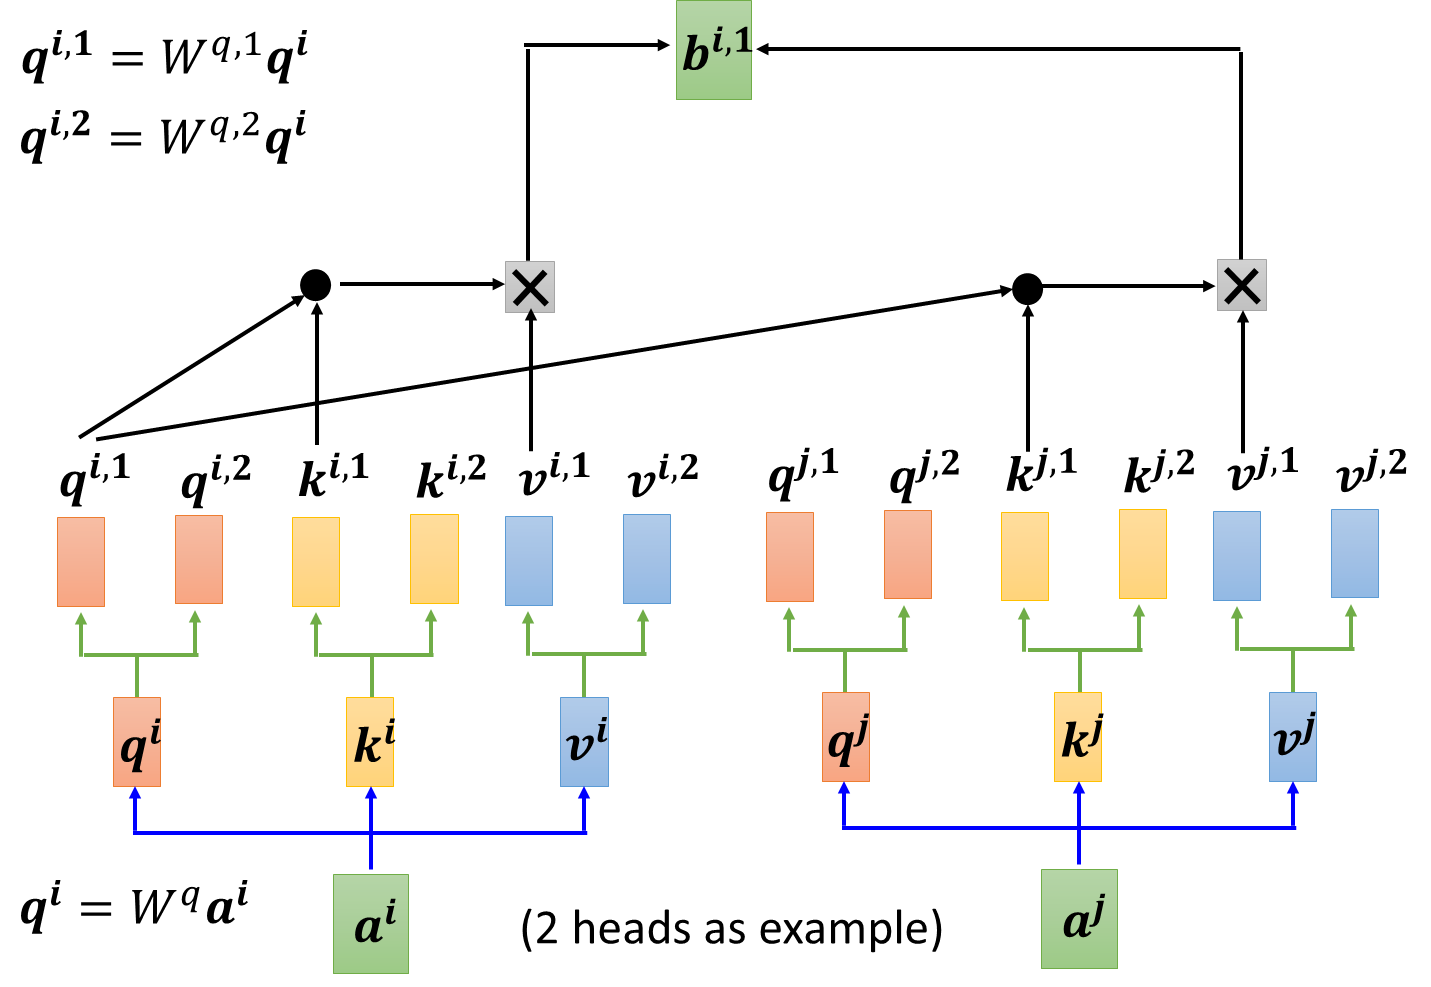

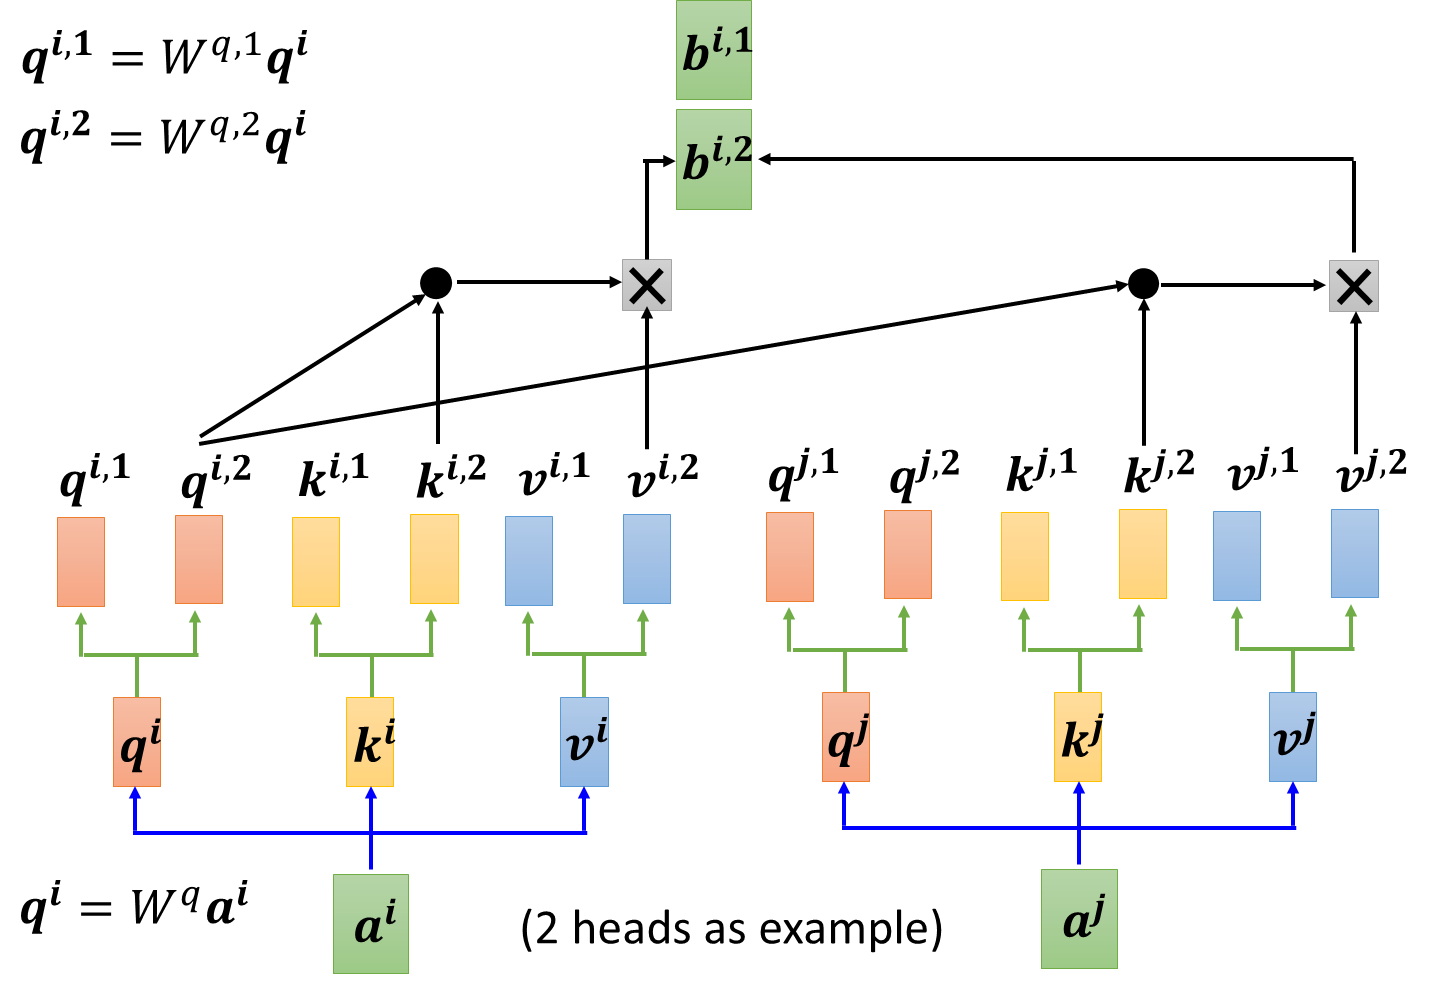

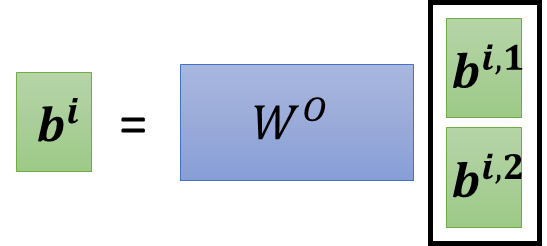

我们参照上述流程，将单头self-attention改造为拥有2个注意力头的多头self-attention：

In [ ]:
class DoubleHeadSelfAttention(nn.Module):

  def __init__(self):
    super().__init__()
    self.W_q = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_k = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_v = nn.Parameter(torch.randn(6, 6) / 100)

    # 注意力头1
    self.W_q_1 = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_k_1 = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_v_1 = nn.Parameter(torch.randn(6, 6) / 100)

    # 注意力头2
    self.W_q_2 = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_k_2 = nn.Parameter(torch.randn(6, 6) / 100)
    self.W_v_2 = nn.Parameter(torch.randn(6, 6) / 100)

    self.W_o = nn.Parameter(torch.randn(12, 6) / 100)

    self.softmax = nn.Softmax(-1)

  def head(self, Q_i, K_i, V_i):
    A_i = self.softmax(Q_i @ K_i.transpose(1, 2))
    return A_i @ V_i

  def forward(self, X):
    Q = X @ self.W_q
    K = X @ self.W_k
    V = X @ self.W_v

    Q_1 = Q @ self.W_q_1
    K_1 = K @ self.W_k_1
    V_1 = V @ self.W_v_1
    H_1 = self.head(Q_1, K_1, V_1)

    Q_2 = Q @ self.W_q_2
    K_2 = K @ self.W_k_2
    V_2 = V @ self.W_v_2
    H_2 = self.head(Q_2, K_2, V_2)

    H = torch.cat([H_1, H_2], dim=-1)
    H_prime = H @ self.W_o
    return H_prime

In [ ]:
X.shape

torch.Size([1, 5, 6])

In [ ]:
self_attention_2_head = DoubleHeadSelfAttention()
H = self_attention_2_head(X.float())
H.shape

torch.Size([1, 5, 6])

重构一下代码，让用户可以指定输入向量的维度以及注意力头的数量：

In [ ]:
class MultiHeadSelfAttention(nn.Module):

  def __init__(self, hidden_size=6, num_heads=2):
    super().__init__()

    self.hidden_size = hidden_size
    self.num_heads = num_heads

    self.W_q = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_k = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_v = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    self.W_q_m = [nn.Parameter(torch.randn(hidden_size, hidden_size) / 100) for _ in range(num_heads)]
    self.W_k_m = [nn.Parameter(torch.randn(hidden_size, hidden_size) / 100) for _ in range(num_heads)]
    self.W_v_m = [nn.Parameter(torch.randn(hidden_size, hidden_size) / 100) for _ in range(num_heads)]

    self.W_o = nn.Parameter(torch.randn(hidden_size * num_heads, hidden_size) / 100)

    self.softmax = nn.Softmax(-1)

  def head(self, Q_i, K_i, V_i):
    A_i = self.softmax(Q_i @ K_i.transpose(1, 2))
    return A_i @ V_i

  def forward(self, X):
    Q = X @ self.W_q
    K = X @ self.W_k
    V = X @ self.W_v

    head_outputs = []
    for i in range(self.num_heads):
      Q_i = Q @ self.W_q_m[i]
      K_i = K @ self.W_k_m[i]
      V_i = V @ self.W_v_m[i]
      H_i = self.head(Q_i, K_i, V_i)
      head_outputs.append(H_i)

    H = torch.cat(head_outputs, dim=-1)
    H_prime = H @ self.W_o
    return H_prime

In [ ]:
multi_head_self_attention = MultiHeadSelfAttention(num_heads=3)
H = multi_head_self_attention(X.float())
H.shape

torch.Size([1, 5, 6])

In [ ]:
multi_head_self_attention = MultiHeadSelfAttention(num_heads=4)
H = multi_head_self_attention(X.float())
H.shape

torch.Size([1, 5, 6])

这种做法参数量级为：$O(m\times d\times d)$，其中$m$是注意力头数，$d$是向量维度

## 3. 多头注意力实现v2：参数量不变的实现

还有一种做法的参数量级为$O(d\times d)$，即随着$m$的增加，参数量不变。

简单来说，就是将$m$组参数的形状从$d$变为$\frac{d}{m}$，但是**需要保证$m$可以整除$d$**.

计算流程（版本2）如下：

1. 利用参数$W^q,W^k,W^v\in\mathbb{R}^{d\times d}$，为$X$计算一组$Q,K,V\in\mathbb{R}^{N\times d}$
  - $Q=XW^q$
  - $K=XW^k$
  - $V=XW^v$
2. 引入$m$组参数$\{W^{q,i},W^{k,i},W^{v,i}\}_{i=1}^m\in\mathbb{R}^{d\times \color{red}{\frac{d}{m}}}$，根据1中计算的$Q,K,V$计算$m$组qkv：$\{Q^{(i)},K^{(i)},V^{(i)}\}_{i=1}^m\in\mathbb{R}^{N\times \color{red}{\frac{d}{m}}}$
  - $Q^{(i)}=QW^{q,i}\in\mathbb{R}^{N\times \color{red}{\frac{d}{m}}}$
  - $K^{(i)}=KW^{k,i}\in\mathbb{R}^{N\times \color{red}{\frac{d}{m}}}$
  - $V^{(i)}=VW^{v,i}\in\mathbb{R}^{N\times \color{red}{\frac{d}{m}}}$
3. 利用每一组$Q^{(i)},K^{(i)}$计算注意力分数：$A^{(i)}=\text{softmax}(Q^{(i)}\times {K^{(i)}}^T) \in \mathbb{R}^{N\times N}$
4. 利用每一组$A^{(i)}$和$V^{(i)}$计算输出：$H^{(i)}=A^{(i)}V^{(i)}\in\mathbb{R}^{N\times \color{red}{\frac{d}{m}}}$
5. 将所有$m$个$H^{(i)}$拼起来，得到$H\in\mathbb{R}^{N\times \color{red}{d}}$
6. 引入参数矩阵$W^o\in\mathbb{R}^{\color{red}{d} \times d}$，计算最终输出$H'=HW^o\in\mathbb{R}^{N\times d}$

代码实现如下：

In [ ]:
class MultiHeadSelfAttention(nn.Module):

  def __init__(self, hidden_size=6, num_heads=2):
    super().__init__()

    # 保证头数整除向量维度
    assert hidden_size % num_heads == 0

    self.hidden_size = hidden_size
    self.num_heads = num_heads

    self.W_q = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_k = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_v = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    # v1
    # self.W_q_m = [nn.Parameter(torch.randn(hidden_size, hidden_size) / 100) for _ in range(num_heads)]
    # self.W_k_m = [nn.Parameter(torch.randn(hidden_size, hidden_size) / 100) for _ in range(num_heads)]
    # self.W_v_m = [nn.Parameter(torch.randn(hidden_size, hidden_size) / 100) for _ in range(num_heads)]

    # v2
    self.W_q_m = [nn.Parameter(torch.randn(hidden_size, hidden_size // num_heads) / 100) for _ in range(num_heads)]
    self.W_k_m = [nn.Parameter(torch.randn(hidden_size, hidden_size // num_heads) / 100) for _ in range(num_heads)]
    self.W_v_m = [nn.Parameter(torch.randn(hidden_size, hidden_size // num_heads) / 100) for _ in range(num_heads)]

    # v1
    # self.W_o = nn.Parameter(torch.randn(hidden_size * num_heads, hidden_size) / 100)

    # v2
    self.W_o = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    self.softmax = nn.Softmax(-1)

  def head(self, Q_i, K_i, V_i):
    A_i = self.softmax(Q_i @ K_i.transpose(1, 2))
    return A_i @ V_i

  def forward(self, X):
    Q = X @ self.W_q
    K = X @ self.W_k
    V = X @ self.W_v

    head_outputs = []
    for i in range(self.num_heads):
      Q_i = Q @ self.W_q_m[i]
      K_i = K @ self.W_k_m[i]
      V_i = V @ self.W_v_m[i]
      H_i = self.head(Q_i, K_i, V_i)
      head_outputs.append(H_i)

    H = torch.cat(head_outputs, dim=-1)
    H_prime = H @ self.W_o
    return H_prime


multi_head_self_attention = MultiHeadSelfAttention(num_heads=2)
H = multi_head_self_attention(X.float())
H.shape

torch.Size([1, 5, 6])

## 4. 多头注意力实现v3：多头并行实现

你可能发现了一个问题，不同注意力头之间的运算是串行的，先算完一个头的输出，再算下一个头的输出。

`num_heads=2`，所以`forward`中的`for`循环执行了2次，拿循环中的第1行来看：

- 第`1`次循环：`Q`(n,6)乘上了`W_q_m`中的第`1`个参数矩阵`W_q_m[0]`(6,3)，得到`Q_1`(n,3).
- 第`2`次循环：`Q`(n,6)乘上了`W_q_m`中的第`2`个参数矩阵`W_q_m[1]`(6,3)，得到`Q_2`(n,3).

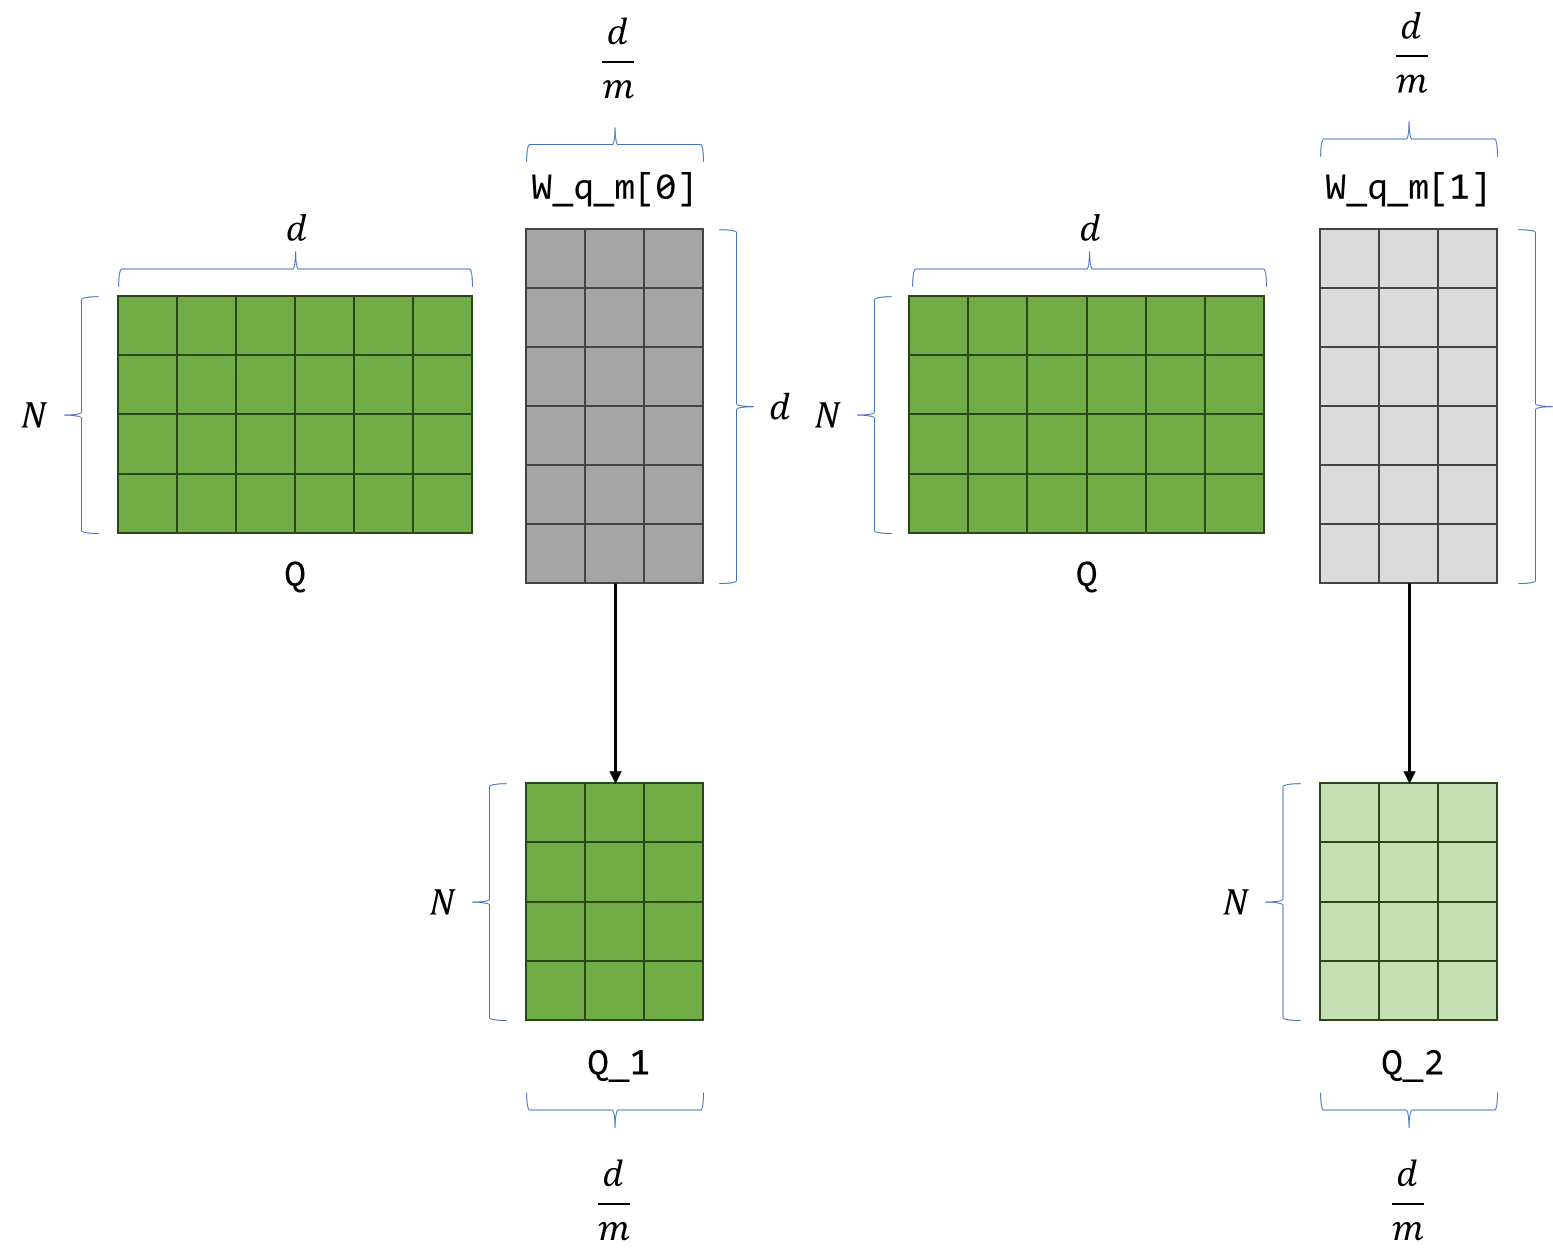

完全可以把`W_q_m[0]`和`W_q_m[1]`拼到一起算：

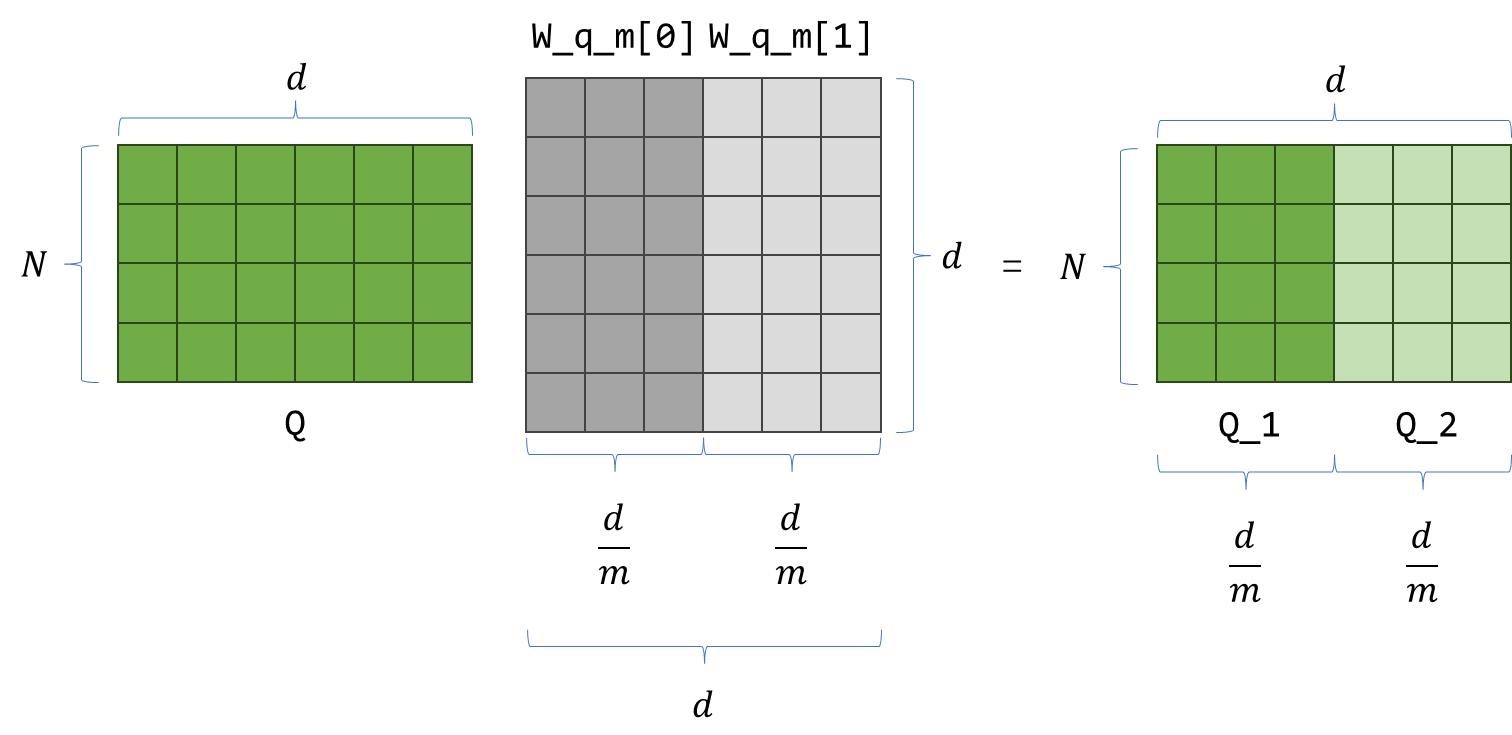

In [ ]:
class MultiHeadSelfAttention(nn.Module):

  def __init__(self, hidden_size=6, num_heads=2):
    super().__init__()

    # 保证头数整除向量维度
    assert hidden_size % num_heads == 0

    self.hidden_size = hidden_size
    self.num_heads = num_heads

    self.W_q = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_k = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_v = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    # v2
    # self.W_q_m = [nn.Parameter(torch.randn(hidden_size, hidden_size // num_heads) / 100) for _ in range(num_heads)]
    # self.W_k_m = [nn.Parameter(torch.randn(hidden_size, hidden_size // num_heads) / 100) for _ in range(num_heads)]
    # self.W_v_m = [nn.Parameter(torch.randn(hidden_size, hidden_size // num_heads) / 100) for _ in range(num_heads)]

    # v3
    self.W_q_m = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)  # 把m个形状为(d, d/m)的参数矩阵拼到一起，又拼回了形状为(d, d)的矩阵
    self.W_k_m = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_v_m = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    self.W_o = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    self.softmax = nn.Softmax(-1)

  def head(self, Q_i, K_i, V_i):
    A_i = self.softmax(Q_i @ K_i.transpose(1, 2))
    return A_i @ V_i

  def forward(self, X):
    Q = X @ self.W_q
    K = X @ self.W_k
    V = X @ self.W_v

    # 并行地算出所有Q_i, K_i, V_i
    Q_m = Q @ self.W_q_m
    K_m = K @ self.W_k_m
    V_m = V @ self.W_v_m

    d_m = self.hidden_size // self.num_heads  # d/m
    head_outputs = []
    for i in range(self.num_heads):
      # 取Q_m,K_m,V_m中的 第i*(d/m)列 至 第(i+1)*(d/m)列
      Q_i = Q_m[:, :, i*d_m:(i+1)*d_m]
      K_i = K_m[:, :, i*d_m:(i+1)*d_m]
      V_i = V_m[:, :, i*d_m:(i+1)*d_m]
      H_i = self.head(Q_i, K_i, V_i)
      head_outputs.append(H_i)

    H = torch.cat(head_outputs, dim=-1)
    H_prime = H @ self.W_o
    return H_prime


multi_head_self_attention = MultiHeadSelfAttention(num_heads=3)
H = multi_head_self_attention(X.float())
H.shape

torch.Size([1, 5, 6])

目前位置，所有$Q^{(i)},K^{(i)},V^{(i)}$已经可以并行算出来了，

但是注意力分数$A^{(i)}$以及每个头的输出$H^{(i)}$还是顺序计算的。

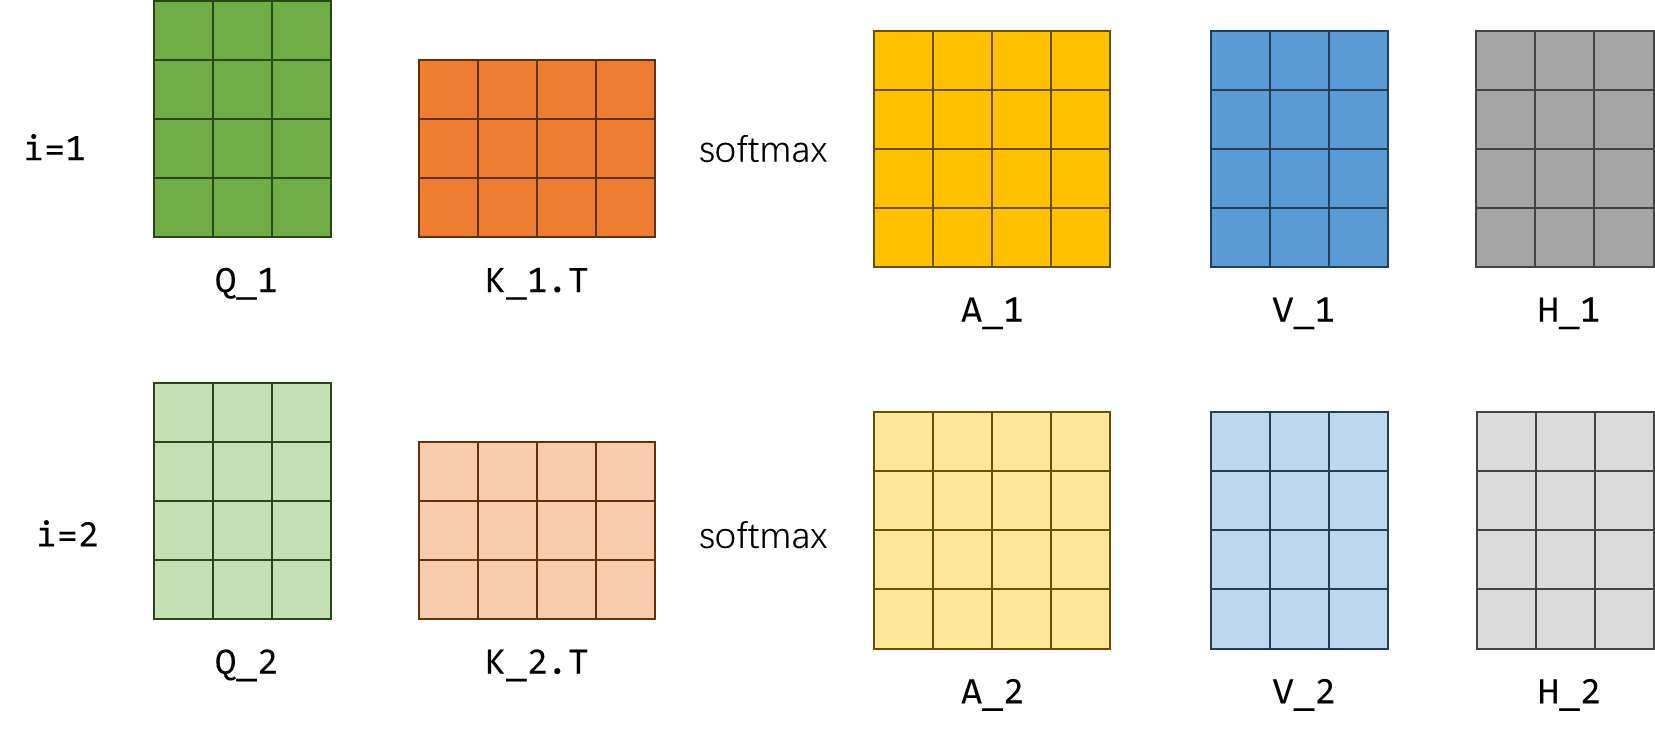

这个的并行就更直观了，直接把所有$Q^{(i)}$和所有$V^{(i)}$叠起来，做批量化的矩阵乘法就行了：

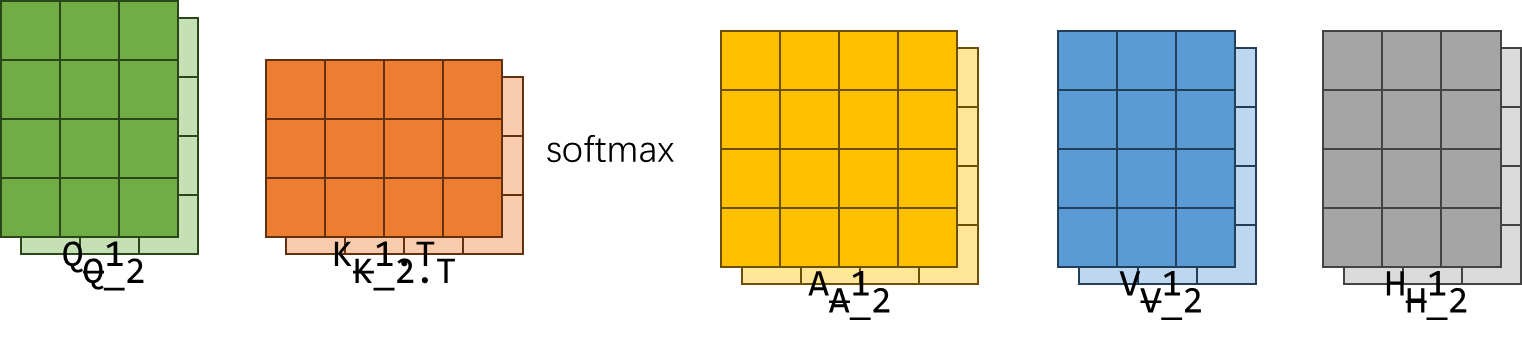

代码实现如下：

In [ ]:
class MultiHeadSelfAttention(nn.Module):

  def __init__(self, hidden_size=6, num_heads=2):
    super().__init__()

    # 保证头数整除向量维度
    assert hidden_size % num_heads == 0

    self.hidden_size = hidden_size
    self.num_heads = num_heads

    self.W_q = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_k = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_v = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    # v3
    self.W_q_m = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)  # 把m个形状为(d, d/m)的参数矩阵拼到一起，又拼回了形状为(d, d)的矩阵
    self.W_k_m = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_v_m = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    self.W_o = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    self.softmax = nn.Softmax(-1)

  def forward(self, X):
    Q = X @ self.W_q
    K = X @ self.W_k
    V = X @ self.W_v

    # 并行地算出所有Q_i, K_i, V_i
    Q_m = Q @ self.W_q_m
    K_m = K @ self.W_k_m
    V_m = V @ self.W_v_m

    d_m = self.hidden_size // self.num_heads  # d/m
    Q_m_stack = Q_m.view(-1, self.num_heads, Q_m.size(1), d_m)  # (B, N, d) -> (B, m, N, d/m)
    K_m_stack = K_m.view(-1, self.num_heads, K_m.size(1), d_m)  # (B, N, d) -> (B, m, N, d/m)
    V_m_stack = V_m.view(-1, self.num_heads, V_m.size(1), d_m)  # (B, N, d) -> (B, m, N, d/m)

    A_m_stack = self.softmax(Q_m_stack @ K_m_stack.transpose(2, 3))  # (B, m, N, d/m) @ (B, m, d/m, N)
    H_m_stack = A_m_stack @ V_m_stack  # (B, m, N, N) @ (B, m, N, d/m)

    H = H_m_stack.view(-1, X.size(1), self.hidden_size)  # (B, m, N, d/m) -> (B, N, d)

    # H = torch.cat(head_outputs, dim=-1)  # 不再需要拼接操作

    H_prime = H @ self.W_o
    return H_prime


multi_head_self_attention = MultiHeadSelfAttention(num_heads=3)
H = multi_head_self_attention(X.float())
H.shape

torch.Size([1, 5, 6])

其中，`Q_m.view`操作重塑了`Q_m`的形状，如下图所示：

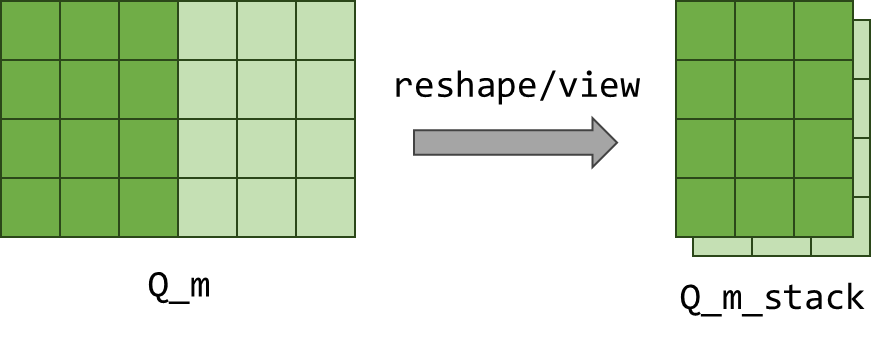

`H_m_stack`可以看作是所有注意力头的输出$H^{(i)}$叠起来得到的张量

`H_m_stack.view`操作重塑输出`H_m_stack`的形状，把**叠**起来的注意力头输出变成**拼**起来的注意力头输出，如下图所示：

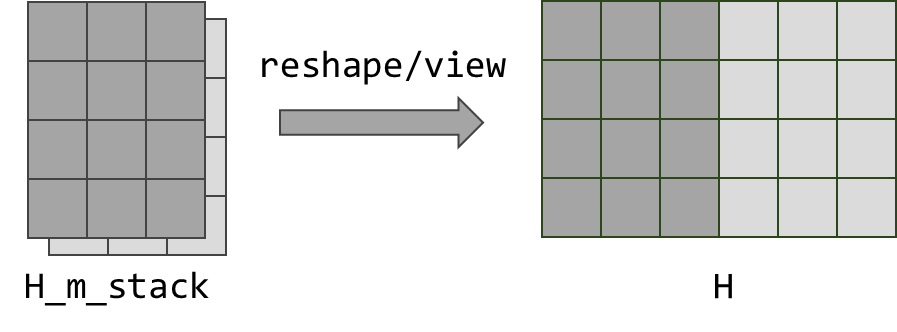

因此`torch.cat`操作也不再需要了，因为经过重新塑形后所有的输出已经被拼起来了

## 5. 多头注意力实现v4：更简洁的实现

**v4是目前大多数语言模型中常见的做法。**

v3的实现中，先和单头注意力机制一样算出了一组`Q,K,V`，然后由`Q,K,V`分别得到相同大小的`Q_m,K_m,V_m`。

那么我们可以直接把`Q,K,V`当作`Q_m,K_m,V_m`来进行后续的计算就好，这样可以省去一次线性变换：

In [ ]:
class MultiHeadSelfAttention(nn.Module):

  def __init__(self, hidden_size=6, num_heads=2):
    super().__init__()

    # 保证头数整除向量维度
    assert hidden_size % num_heads == 0

    self.hidden_size = hidden_size
    self.num_heads = num_heads

    self.W_q = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_k = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_v = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    # v3（弃用）
    # self.W_q_m = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)  # 把m个形状为(d, d/m)的参数矩阵拼到一起，又拼回了形状为(d, d)的矩阵
    # self.W_k_m = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    # self.W_v_m = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    self.W_o = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    self.softmax = nn.Softmax(-1)

  def forward(self, X):
    # 并行地算出所有Q_i, K_i, V_i（v4）
    Q_m = X @ self.W_q
    K_m = X @ self.W_k
    V_m = X @ self.W_v

    # 并行地算出所有Q_i, K_i, V_i（v3，弃用）
    # Q_m = Q @ self.W_q_m
    # K_m = K @ self.W_k_m
    # V_m = V @ self.W_v_m

    d_m = self.hidden_size // self.num_heads  # d/m
    Q_m_stack = Q_m.view(-1, self.num_heads, Q_m.size(1), d_m)  # (B, N, d) -> (B, m, N, d/m)
    K_m_stack = K_m.view(-1, self.num_heads, K_m.size(1), d_m)  # (B, N, d) -> (B, m, N, d/m)
    V_m_stack = V_m.view(-1, self.num_heads, V_m.size(1), d_m)  # (B, N, d) -> (B, m, N, d/m)

    A_m_stack = self.softmax(Q_m_stack @ K_m_stack.transpose(2, 3))  # (B, m, N, d/m) @ (B, m, d/m, N)
    H_m_stack = A_m_stack @ V_m_stack  # (B, m, N, d/m) @ (B, m, N, d/m)

    H = H_m_stack.view(-1, X.size(1), self.hidden_size)  # (B, m, N, d/m) -> (B, N, d)

    # H = torch.cat(head_outputs, dim=-1)  # 不再需要拼接操作

    H_prime = H @ self.W_o
    return H_prime


multi_head_self_attention = MultiHeadSelfAttention(num_heads=3)
H = multi_head_self_attention(X.float())
H.shape

torch.Size([1, 5, 6])

## 6. 对比实验

先把attention mask机制加上，让填充部分不参与计算：

In [ ]:
class MultiHeadSelfAttention(nn.Module):

  def __init__(self, hidden_size=6, num_heads=2):
    super().__init__()

    # 保证头数整除向量维度
    assert hidden_size % num_heads == 0

    self.hidden_size = hidden_size
    self.num_heads = num_heads

    self.W_q = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_k = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_v = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_o = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    self.softmax = nn.Softmax(-1)

  def get_attention_mask_2d(self, attention_mask):
    batch_size = attention_mask.size(0)
    mask_len = attention_mask.size(1)
    attention_mask_2d = attention_mask[:, None, None, :].expand(batch_size, self.num_heads, mask_len, mask_len).to(torch.float32)
    inverted_mask = 1.0 - attention_mask_2d
    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(torch.float32).min)

  def forward(self, X, attention_mask):
    Q_m = X @ self.W_q
    K_m = X @ self.W_k
    V_m = X @ self.W_v

    d_m = self.hidden_size // self.num_heads  # d/m

    Q_m_stack = Q_m.view(-1, self.num_heads, Q_m.size(1), d_m)
    K_m_stack = K_m.view(-1, self.num_heads, K_m.size(1), d_m)
    V_m_stack = V_m.view(-1, self.num_heads, V_m.size(1), d_m)

    mask = self.get_attention_mask_2d(attention_mask)
    A_m_stack = self.softmax(Q_m_stack @ K_m_stack.transpose(2, 3) + mask)
    H_m_stack = A_m_stack @ V_m_stack

    H = H_m_stack.view(-1, X.size(1), self.hidden_size)

    H_prime = H @ self.W_o
    return H_prime

与[Self Attention Training Tutorial](https://colab.research.google.com/drive/1d7qfwr32lkq3hZEZ1jNaIJ7Rz8zLNkfl)中类似，构建一个完整的预测模型：

In [ ]:
class MultiHeadSelfAttentionPredictModel(nn.Module):

  def __init__(self, hidden_size=6, num_heads=2):
    super().__init__()
    self.attn = MultiHeadSelfAttention(hidden_size, num_heads)
    self.fnn = nn.Sequential(
        nn.Linear(hidden_size, hidden_size * 2),
        nn.Linear(hidden_size * 2, hidden_size)
    )
    self.act = nn.ReLU()
    self.pred_head = nn.Linear(hidden_size, 1)

  def forward(self, X, attention_mask):
    H_attn = self.attn(X, attention_mask)
    H_fnn = self.fnn(H_attn)
    H_act = self.act(H_fnn)

    # 忽略填充的部分求均值
    H_pooled = H_act.sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)

    y = self.pred_head(H_pooled) * 100  # 输出头
    return y.squeeze(-1)

封装一个训练函数，可以对不同的模型进行训练，训练流程讲解详见[Self Attention Training Tutorial](https://colab.research.google.com/drive/1d7qfwr32lkq3hZEZ1jNaIJ7Rz8zLNkfl)：

In [ ]:
def train(model):
  optimizer = AdamW(model.parameters(), lr=0.01)
  num_train_epochs = 20
  scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=num_train_epochs)


  def get_lr(optimizer):
    for param_group in optimizer.param_groups:
      return param_group['lr']


  for i_epoch in range(num_train_epochs):
    total_loss = []
    for X, y, attention_mask in loader_train:
      X = torch.tensor(X, dtype=torch.float32)
      y = torch.tensor(y, dtype=torch.float32)
      y_pred = model(X, attention_mask)
      loss = ((y_pred - y) ** 2).mean()  # 均方误差
      total_loss.append(loss)
    avg_loss = sum(total_loss) / len(total_loss)
    print("="*100)
    print("Loss:", avg_loss.item())
    print("LR:", get_lr(optimizer))
    print("="*100)
    optimizer.zero_grad()
    avg_loss.backward()
    optimizer.step()
    scheduler.step()  # 调整学习率

初始化一个单头模型和一个多头模型：

In [ ]:
model_single_head = MultiHeadSelfAttentionPredictModel(num_heads=1)
model_multi_head = MultiHeadSelfAttentionPredictModel(num_heads=2)

注意，这里`MultiHeadSelfAttentionPredictModel(num_heads=1)`指定使用1个注意力头

但是与[Self Attention Training Tutorial](https://colab.research.google.com/drive/1d7qfwr32lkq3hZEZ1jNaIJ7Rz8zLNkfl)中的single-head实现相比，多了一个`W_o`参数

然后开始训练：

In [ ]:
train(model_single_head)

<ipython-input-46-336ecdcc6b1e>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-46-336ecdcc6b1e>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


Loss: 12901929.0
LR: 0.01
Loss: 11074756.0
LR: 0.00975
Loss: 6739936.0
LR: 0.0095
Loss: 1579511.0
LR: 0.00925
Loss: 2608285.0
LR: 0.009
Loss: 2544589.0
LR: 0.008749999999999999
Loss: 618941.0625
LR: 0.008499999999999999
Loss: 1288342.875
LR: 0.008249999999999999
Loss: 1808217.625
LR: 0.007999999999999998
Loss: 1383976.625
LR: 0.007749999999999998
Loss: 732930.625
LR: 0.007499999999999999
Loss: 575856.875
LR: 0.007249999999999999
Loss: 921171.1875
LR: 0.006999999999999999
Loss: 1125525.625
LR: 0.006749999999999999
Loss: 911875.6875
LR: 0.0065
Loss: 626961.625
LR: 0.0062499999999999995
Loss: 557693.125
LR: 0.005999999999999999
Loss: 668675.5625
LR: 0.00575
Loss: 792873.125
LR: 0.0055
Loss: 822162.25
LR: 0.00525


In [ ]:
train(model_multi_head)

<ipython-input-46-336ecdcc6b1e>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-46-336ecdcc6b1e>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


Loss: 13199451.0
LR: 0.01
Loss: 10118367.0
LR: 0.00975
Loss: 3852401.0
LR: 0.0095
Loss: 1026514.25
LR: 0.00925
Loss: 2605556.0
LR: 0.009
Loss: 142518.953125
LR: 0.008749999999999999
Loss: 785875.3125
LR: 0.008499999999999999
Loss: 1472248.5
LR: 0.008249999999999999
Loss: 1115568.25
LR: 0.007999999999999998
Loss: 356276.03125
LR: 0.007749999999999998
Loss: 118930.1640625
LR: 0.007499999999999999
Loss: 630791.9375
LR: 0.007249999999999999
Loss: 846228.5625
LR: 0.006999999999999999
Loss: 424838.8125
LR: 0.006749999999999999
Loss: 105944.515625
LR: 0.0065
Loss: 174012.5625
LR: 0.0062499999999999995
Loss: 381018.3125
LR: 0.005999999999999999
Loss: 477959.84375
LR: 0.00575
Loss: 404537.875
LR: 0.0055
Loss: 240217.28125
LR: 0.00525


同样封装一个评估函数，评估不同的模型：

In [ ]:
def evaluate(model):
  total_error = []
  predictions = []
  for X, y, attention_mask in loader_test:
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    with torch.no_grad():
      y_pred = model(X, attention_mask)
    predictions.extend(y_pred.tolist())
    error = ((y_pred - y).abs() / y.abs()).mean()
    total_error.append(error)
  avg_error = sum(total_error) / len(total_error)
  return avg_error.item()

In [ ]:
error_single_head = evaluate(model_single_head)
print(f"Error: {error_single_head*100:.2f}%")

Error: 18.90%


<ipython-input-23-0857cadeb5e9>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-23-0857cadeb5e9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


In [ ]:
error_multi_head = evaluate(model_multi_head)
print(f"Error: {error_multi_head*100:.2f}%")

Error: 6.71%


<ipython-input-23-0857cadeb5e9>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-23-0857cadeb5e9>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


## 7. 明明参数量一样为什么multi-head更好？

我们来看一下两个模型的参数量：

In [ ]:
single_head_param_count = sum(p.numel() for p in model_single_head.parameters())
multi_head_param_count = sum(p.numel() for p in model_multi_head.parameters())

In [ ]:
print(single_head_param_count)
print(multi_head_param_count)

313
313


两个模型参数量是一模一样的，都是313

但是经过相同超参数配置的训练流程后，multi-head比single-head的预测误差低了12.19个百分点。

原因在于，multi-head进行了更加精细的注意力分数计算。

在single-head self-attention中，一组$Q,K$只能算出一个`(N,N)`的注意力分数矩阵：

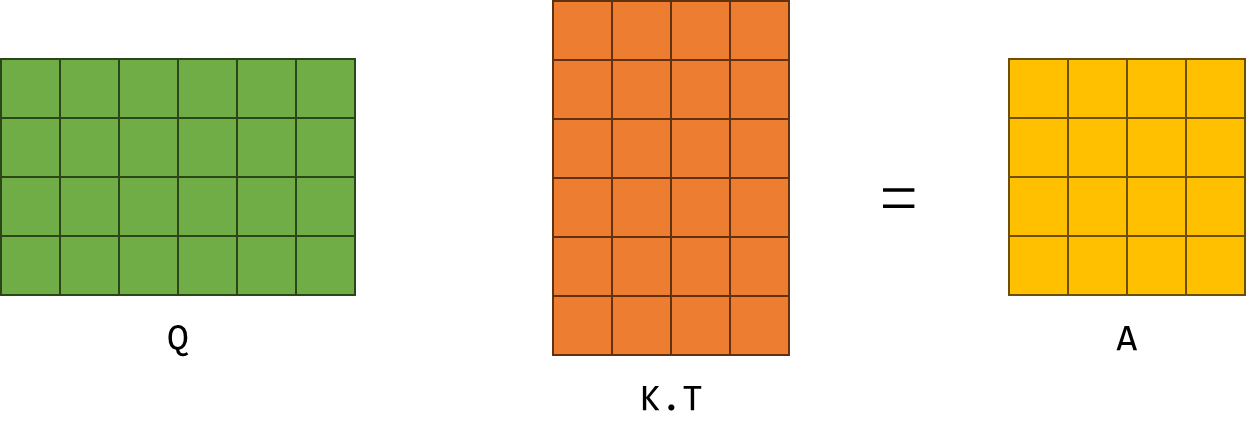

而multi-head self-attention相当于把$Q$和$K$都掰成了好几份，每一份作一个矩阵乘法，并且每一份都能得到一个`(N,N)`的注意力分数矩阵。

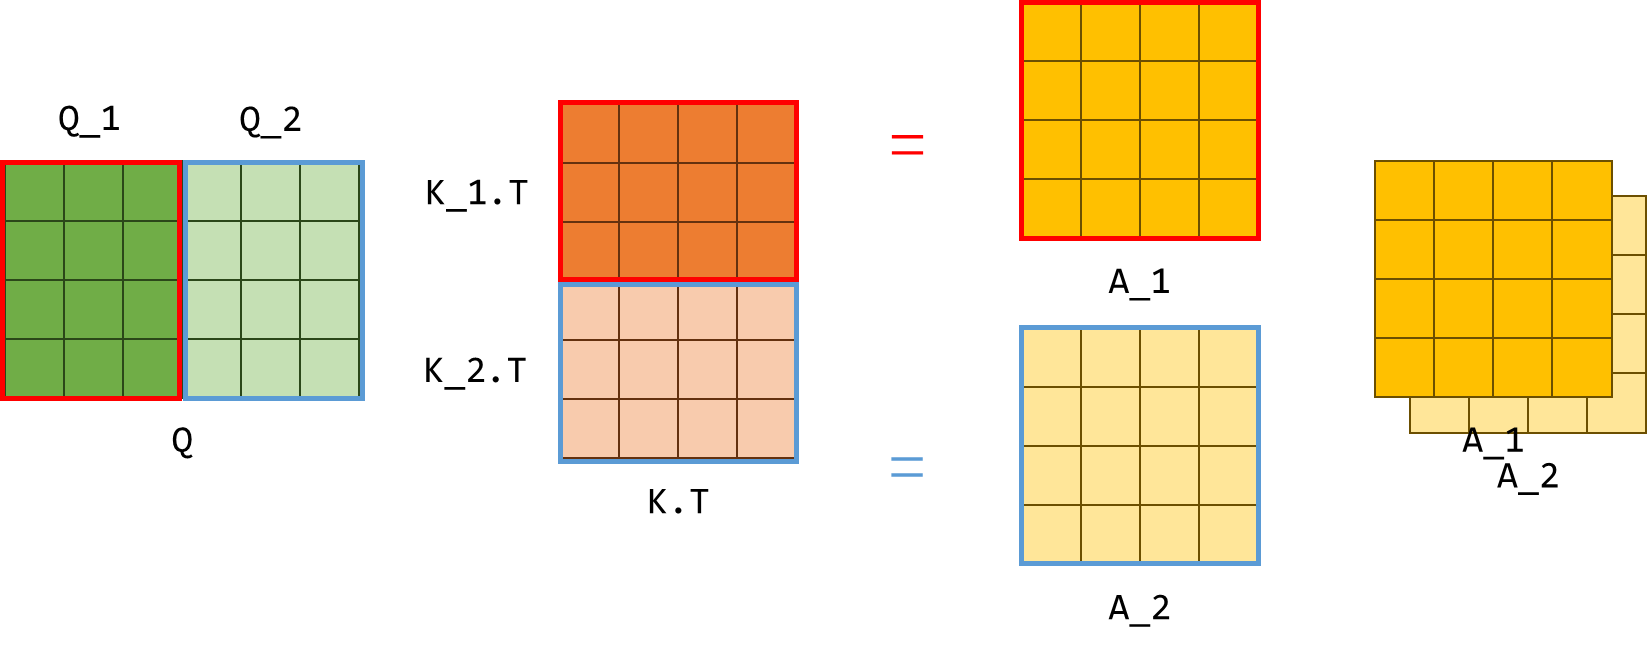

如果使用multi-head，序列中第`i`个位置到第`j`个位置的注意力有两个不同的衡量分数，分别为`A_1[i,j]`和`A_2[i,j]`

如果使用single-head，序列中第`i`个位置到第`j`个位置的注意力就只有一个衡量分数了，即`A[i,j]`

实际上，从图中的运算可以看出，`A=A_1+A_2`，所以有`A[i,j]=A_1[i,j]+A_2[i,j]`

反过来想，如果使用single-head，相当于把使用multi-head算出来的注意力分数直接加起来了，从而导致信息损失。